In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from random import shuffle
from nltk.tag import pos_tag

In [3]:
#nltk.download("punkt")
#nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
df=pd.read_json('winemag-data-130k-v2.json')
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)
pd.set_option('max_colwidth', -1)

<ipython-input-5-36750f235585>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


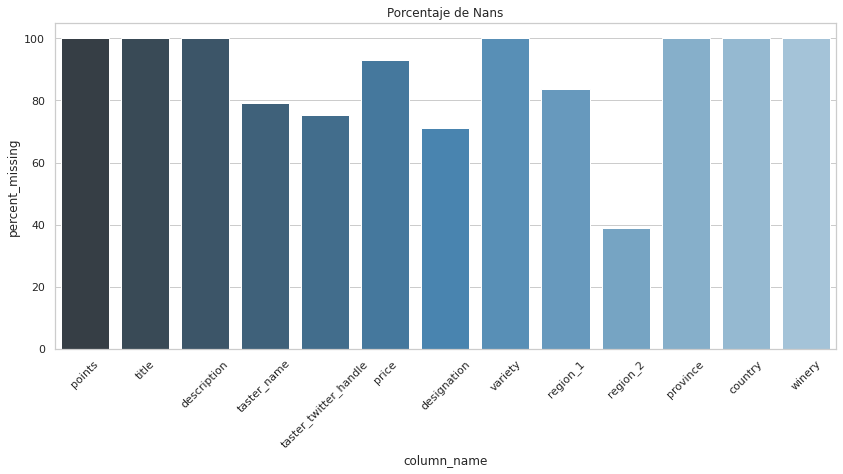

In [6]:
percent_missing = df.notnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
plt.figure(figsize = (14,6))
sns.set(style="whitegrid")
plt.title('Porcentaje de Nans')
sns.barplot(x = 'column_name', 
            y="percent_missing", 
            data=missing_value_df,
            palette=("Blues_d")
           )
#sns.set_context("poster")
locs, labels = plt.xticks(rotation=45)
plt.show()

# Funciones

In [7]:
def fun_encoding(undf,listEncoding,baseMetric,agg_funtions,suffixes=None):
    
    df_agrup=undf.groupby(by=listEncoding,as_index =False)[baseMetric].aggregate(agg_funtions)
    df_agrup.columns=df_agrup.columns.map('_'.join).str.strip('_')
    df_agrup.reset_index(inplace=True)
    undf=pd.merge(undf,df_agrup, on=listEncoding,suffixes=('',suffixes))
    undf.drop(columns=listEncoding,axis=0,inplace=True)
    return undf

In [8]:
def pastel_plot(data, x, y):
    plt.figure(figsize = (15,6))
    plt.title('{} histogram - dataset'.format(x))
    sns.set_color_codes("dark")
    sns.barplot(x = x, y=y, data=data)
    locs, labels = plt.xticks()
    plt.show()

In [9]:
def remove_stopwords(word_list):
        processed_word_list = []
        for word in word_list:
            word = word.lower() # in case they arenet all lower cased
            if word not in stop_words:
                processed_word_list.append(word)
        return processed_word_list

# EDA

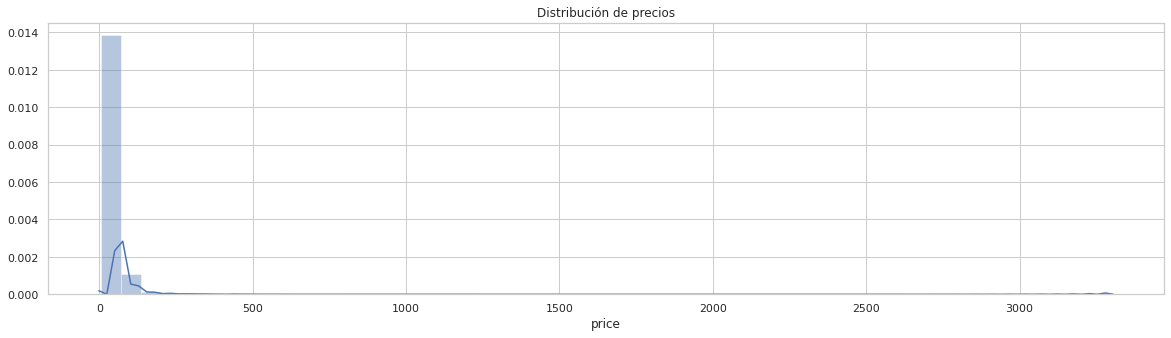

In [10]:
plt.figure(figsize=(20,5))
plt.title("Distribución de precios")
sns.distplot(df[df.price.notnull()].price)

In [11]:
df[df.price>200].points.mean()

94.38195488721804

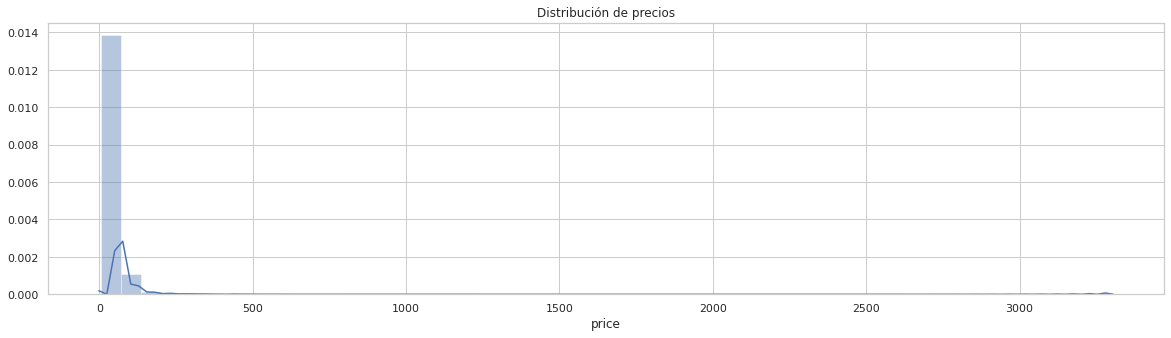

In [12]:
plt.figure(figsize=(20,5))
plt.title("Distribución de precios")
sns.distplot(df[df.price.notnull()].price)

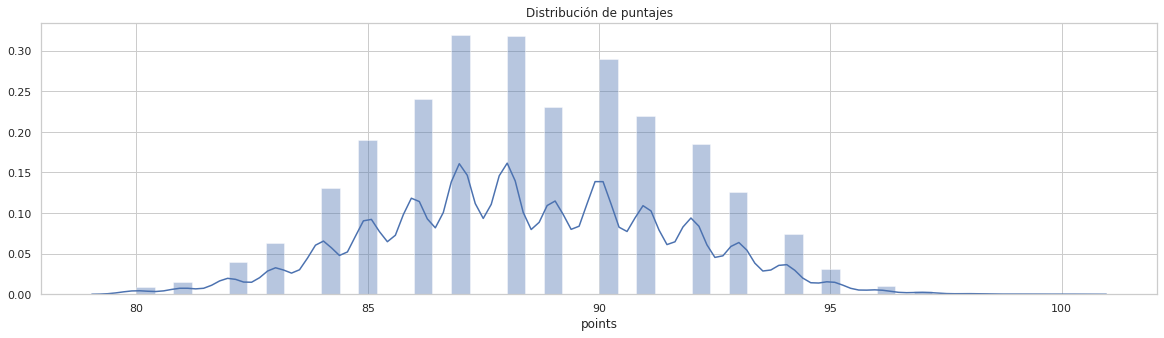

In [13]:
plt.figure(figsize=(20,5))
plt.title("Distribución de puntajes")
sns.distplot(df[df.price.notnull()].points)

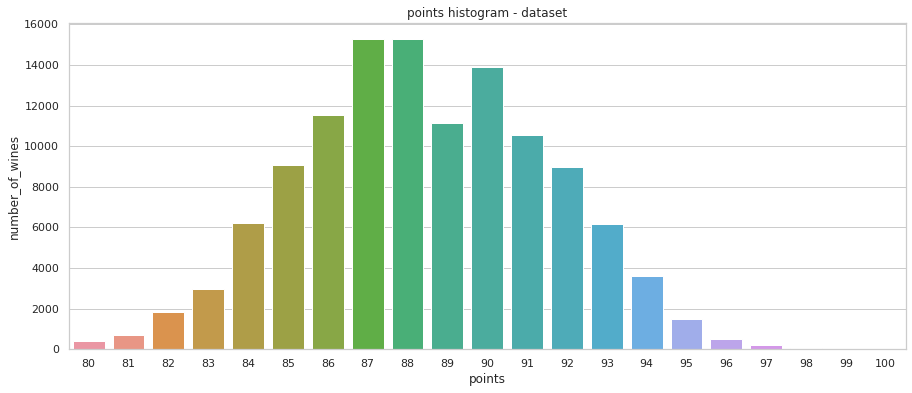

In [14]:
temp = df["points"].value_counts()
df_temp = pd.DataFrame({'points': temp.index,
                   'number_of_wines': temp.values
                  })
pastel_plot(df_temp,'points', 'number_of_wines')

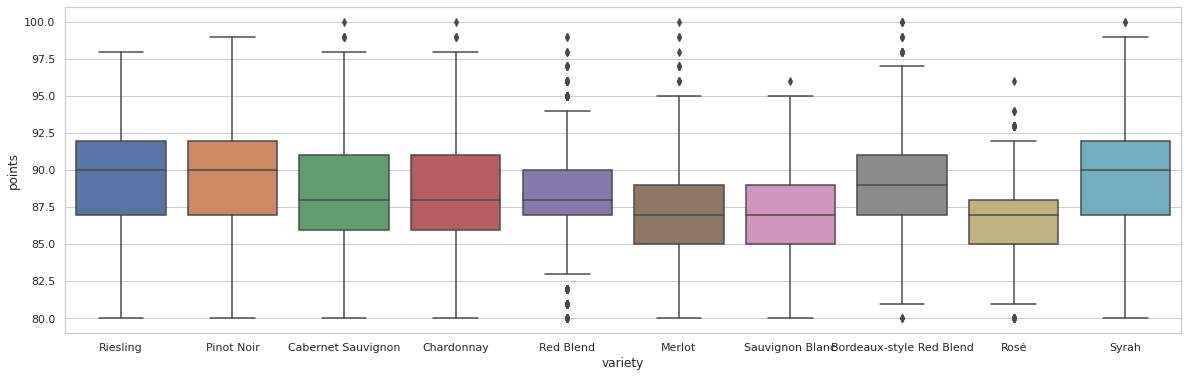

In [15]:
plt.figure(figsize = (20,6))
sns.boxplot(
    x = 'variety',
    y = 'points',
    data = df[df.variety.isin(df.variety.value_counts().head(10).index)]
)

In [16]:
aux=df.groupby(['country'])['price','points'].mean().reset_index().sort_values('price',ascending=False)

<ipython-input-16-f9e832bc2c9f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux=df.groupby(['country'])['price','points'].mean().reset_index().sort_values('price',ascending=False)


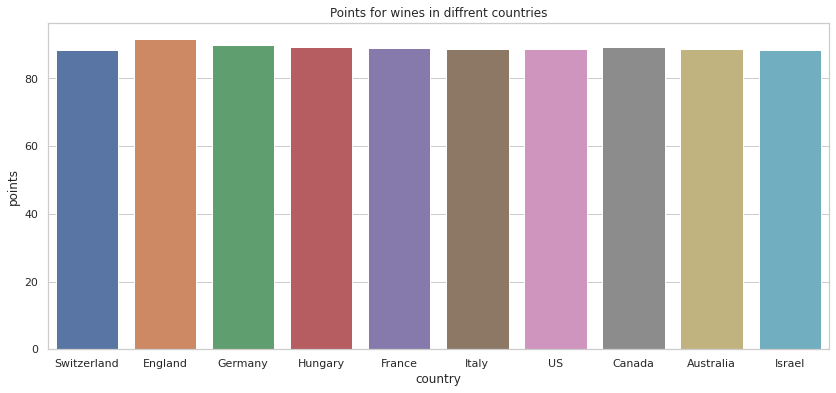

In [17]:
plt.figure(figsize = (14,6))
plt.title('Points for wines in diffrent countries')
sns.set_color_codes("pastel")
sns.barplot(x = 'country', y="points", data=aux.head(10))
locs, labels = plt.xticks()
plt.show()

## Precio

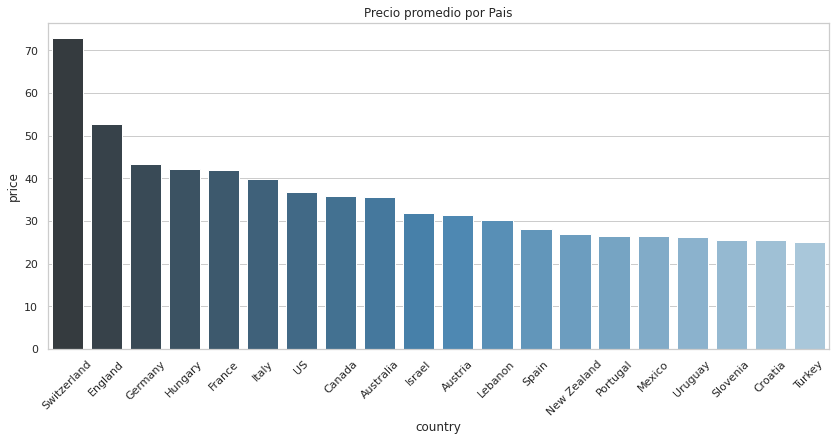

In [18]:
plt.figure(figsize = (14,6))
sns.set(style="whitegrid")
plt.title('Precio promedio por Pais')
sns.barplot(x = 'country', 
            y="price", 
            data=aux.head(20),
            palette=("Blues_d")
           )
#sns.set_context("poster")
locs, labels = plt.xticks(rotation=45)
plt.show()

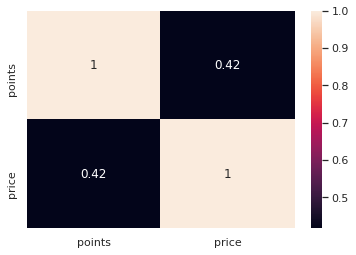

In [19]:
sns.heatmap(df.corr(), annot = True)
plt.show()

## Preprocessing

In [20]:
stop_words = stopwords.words('english')

In [21]:
wine_stopwords = ['drink','wine','wines','flavor','flavors','note','notes','palate','finish','hint','hints','show','shows']
for w in wine_stopwords:
    stop_words.append(w)

In [22]:
df['palabras']=df.apply(lambda row: re.findall('[\w]+', row.description.lower()),axis=1)
df['longitud_descripcion']=df.description.str.len()
df['palabras']=df.apply(lambda row: remove_stopwords(row.palabras),axis=1)
df['cantidad_palabras']=df.apply(lambda row: len(row.palabras),axis=1)

## Saco palabras para mejores y peores del 25%

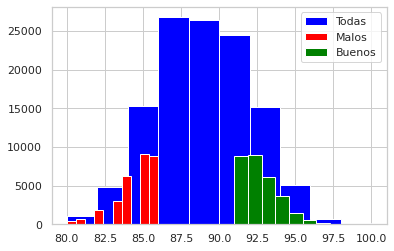

In [23]:
df_sorted = df.sort_values(by='points', ascending=True)

num_of_wines = df_sorted.shape[0]
worst = df_sorted.head(int(0.25*num_of_wines))  # 25 % 
best = df_sorted.tail(int(0.25*num_of_wines))  # 25 %
plt.hist(df['points'], color='blue', label='Todas')
plt.hist(worst['points'], color='red', label='Malos')
plt.hist(best['points'], color='green', label='Buenos')
plt.legend()
plt.show()


## Armo lista de palabras de buenos y malos

In [24]:
worst = worst.dropna(subset=['palabras'])  # drop all NaNs
best = best.dropna(subset=['palabras'])  # drop all NaNs

all_words_good = []  
all_words_bad = []
for list_palabras in worst['palabras'].values:
    for palabra in list_palabras:
        all_words_bad.append(palabra)
for list_palabras in best['palabras'].values:
    for palabra in list_palabras:
        all_words_good.append(palabra)
all_words_bad = list(FreqDist(all_words_bad).keys())[:3000]  # make FreqList
all_words_good = list(FreqDist(all_words_good).keys())[:3000]

# Armo listado de adjetivos de buenos y malos

In [25]:
words_tagged_bad = nltk.pos_tag(all_words_bad)
words_tagged_good = nltk.pos_tag(all_words_good)
adj_negatives = [word_tagged[0] for word_tagged in words_tagged_bad if word_tagged[1] in ("JJ","JJR","JJS")]
adj_positives= [word_tagged[0] for word_tagged in words_tagged_good if word_tagged[1]  in ("JJ","JJR","JJS")]

In [26]:
len(adj_positives),len(adj_negatives)

(683, 704)

In [27]:
type(adj_positives)

list

In [ ]:
%%time
df['cantidad_adj_positivos']=df.apply(lambda row: len([i for i in adj_positives if i in row.palabras ]),axis=1)
df['cantidad_adj_negativos']=df.apply(lambda row: len([i for i in adj_negatives if i in row.palabras ]),axis=1)
df['cantidad_palabras_positivas']=df.apply(lambda row: len([i for i in all_words_good if i in row.palabras ]),axis=1)
df['cantidad_palabras_negativas']=df.apply(lambda row: len([i for i in all_words_bad if i in row.palabras ]),axis=1)

In [ ]:
df['anio']=df.apply(lambda x:int(re.findall(r'\d+',x.title)[-1]) if len(re.findall(r'\d+',x.title))!=0 else np.nan,axis=1)

## Completo camp con "Unknown" para el encoding

In [ ]:
df['country'].fillna('Unknown',inplace=True)
df['province'].fillna('Unknown',inplace=True)
df['region_1'].fillna('Unknown',inplace=True)
df['region_2'].fillna('Unknown',inplace=True)
df['taster_name'].fillna('Unknown',inplace=True)
df['variety'].fillna('Unknown',inplace=True)
df['winery'].fillna('Unknown',inplace=True)

## Encoding para variables tipo texto

In [ ]:
df=fun_encoding(df,['province','region_1','region_2'],['price','points'],[min, np.mean, np.median, max, sum])
df=fun_encoding(df,['country'],['price','points'],[min, np.mean, np.median, max, sum],suffixes='_country')
df=fun_encoding(df,['taster_name'],['price','points'],[min, np.mean, np.median, max, sum],suffixes='_taster')
df=fun_encoding(df,['variety'],['price'],[min, np.mean, np.median, max, sum],suffixes='_variaty')
df=fun_encoding(df,['winery'],['price'],[min, np.mean, np.median, max, sum],suffixes='_winery')

In [ ]:
df.drop(columns=['taster_twitter_handle','title','designation','description','palabras'],axis=0,inplace=True)

In [37]:
df_corr=df.corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

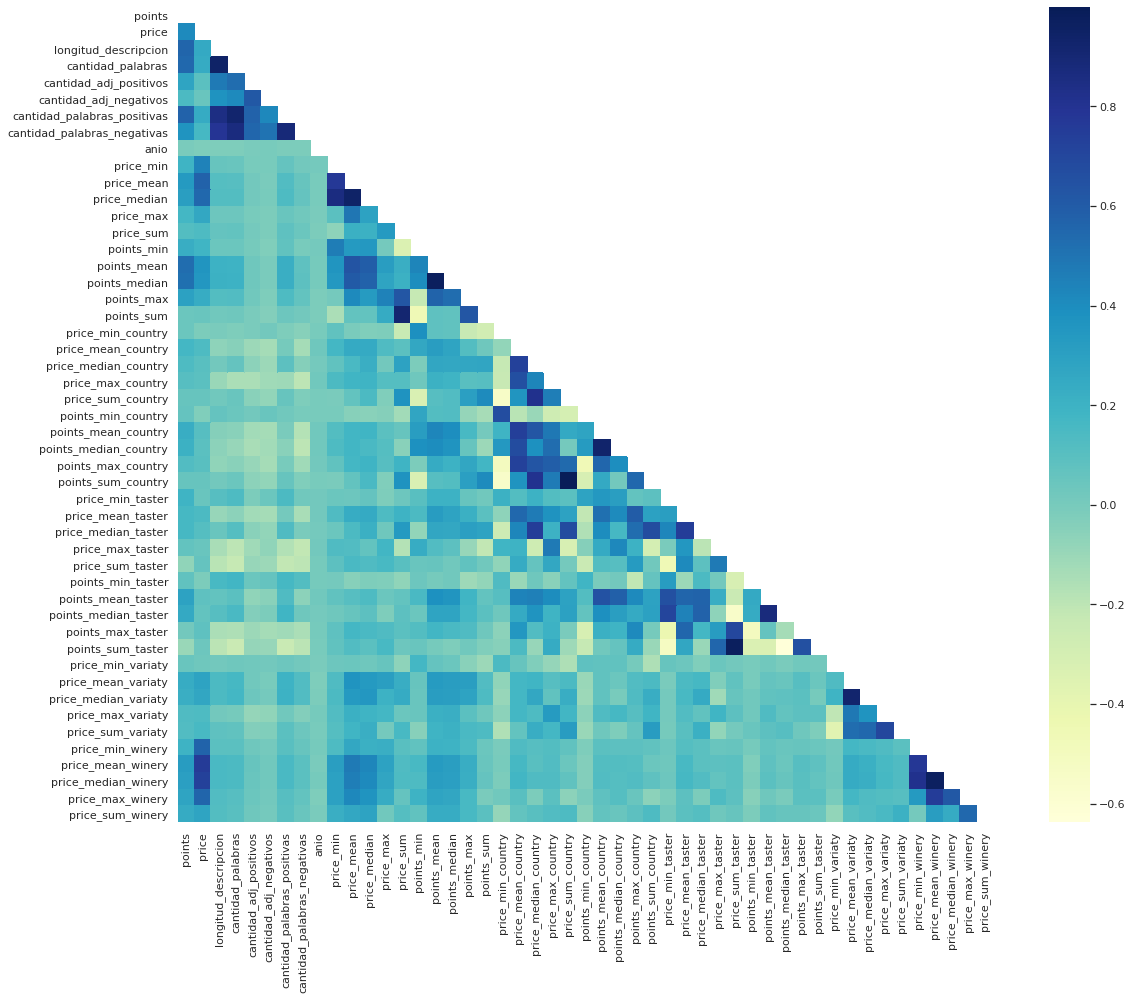

In [39]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_corr,mask = mask, cmap="YlGnBu",square=True)

In [42]:
df=df[df.price.notnull()]
df.reset_index(inplace=True,drop=True)

In [43]:
df.anio.fillna(0,inplace=True)

In [48]:
df.reset_index(inplace=True,drop=True)

In [51]:
df.drop(columns=['level_0','index'],inplace=True)

## Guardo pickle

In [53]:
import pickle
# Save tuple
pickle.dump(df, open("desafio_1_data.pkl", 'wb'))